# Predicting Movie Rates with Decision Tree

In this report, we are building step by step a decision tree to predict user ratings on movies using the MovieLens dataset, available at http://grouplens.org/datasets/movielens/

The dataset is composed by 3 main files:

**movies.dat:** this file contains information of all movies, in the format < movie id > :: < movie name > :: < pipe separeted list of genders >

**users.dat:** this file contains information of all users, in the format < user id > :: < user gender > :: < user age > :: < ocupation > :: < zip code > 

**ratings.dat:** this file contains information of all ratings, in the format < user id > :: < movie id > :: < rating > :: < timestamp >


## Pre-processing data

#### Choosing features and building data frame

The first step in this project is to join the data in the 3 data files into a feature and a label matrices. It is very important to carefully choose the attributes to build and train the tree.

In our first approach, we will try to predict the rating without using explicitely the id of the movie and the id of the user. This is because, although they could be good criteria, the large amount of different values in those columns represent a great computational cost. The same goes to the user's zip code and timestamps. For those features, it is unlikely that they wield much relevant information. Finally, we will be using the genres of the movies. There are 17 genres (Action, Adventure, Animation, Children, Comedy, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War and Western). We will store all that information in a single number, build with the binary representation of the movies genres. Since there are 17 different genres, we will be storing numbers from 0 to 2^17-1 = 131071. In practice, we expect a lot less different genre values (we will measure that later).

The function **build_features** does all the processing, and returns the dataframe we will be using. The function **get_genre_id** takes a list of genres and returns its corresponding id.

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np

def get_genre_id(genres_list):
    """
    return the integer id of a list of genres, 
    which is the integer corresponding to the binary intersection of the list with all the genres
    """
    # movie genres
    genres = [
        'Action',
        'Adventure',
        'Animation',
        'Children\'s',
        'Comedy',
        'Documentary',
        'Drama',
        'Fantasy',
        'Film-Noir',
        'Horror',
        'Musical',
        'Mystery',
        'Romance',
        'Sci-Fi',
        'Thriller',
        'War',
        'Western'
    ]
    # creating id
    id = 0
    weight = 1
    for genre in genres:
        if genre in genres_list:
            id += weight
        weight*=2
    return str(id)
    

def build_features(drops):
    """
    read data from movies, users and rating and return a single pandas dataframe
    of the joined tables, containing all info on ratings
    """
    print "Building features. This may take a while..."
    # reading movies data
    movies_df = pd.DataFrame(columns=['movie_id', 'genre'])
    with open('../data/movies.dat','r') as file:
        lines = file.readlines()
        for idx in range(len(lines)):
            row = lines[idx].split("::")
            movie_genres = row[-1][:-1].split('|')
            row = row[:-2] # ignore genre and movie name
            row.append(get_genre_id(movie_genres)) # append genre id
            movies_df.loc[idx] = row
    
    # reading users data
    users_df = pd.read_table('../data/users.dat', 
                    names=['user_id', 'gender', 'age', 'ocupation', 'zip_code'], 
                     sep='::', engine='python')
    users_df['user_id'] = users_df['user_id'].apply(lambda x: str(x))
    users_df['ocupation'] = users_df['ocupation'].apply(lambda x: str(x))
    
    # reading ratings data
    ratings_df = pd.read_table('../data/ratings.dat', 
                    names=['user_id', 'movie_id', 'rating', 'timestamp'], 
                    sep='::', engine='python')
    ratings_df['movie_id'] = ratings_df['movie_id'].apply(lambda x: str(x))
    ratings_df['user_id'] = ratings_df['user_id'].apply(lambda x: str(x))
    
    # join tables
    user_ratings_df = ratings_df.merge(users_df, how='inner', on='user_id')
    features_df = user_ratings_df.merge(movies_df, how='inner', on='movie_id')
    
    # drop unwanted features
    for drop_feature in drops:
        features_df = features_df.drop(drop_feature, 1)

    # print first 5 rows
    print "Done. Showing 5 first rows:"
    display(features_df.head()) 
    
    return features_df
    
data = build_features(['timestamp', 'zip_code', 'user_id', 'movie_id'])

Building features. This may take a while...
Done. Showing 5 first rows:


,rating,gender,age,ocupation,genre
0,5,F,1,10,64
1,5,M,56,16,64
2,4,M,25,12,64
3,4,M,25,7,64
4,5,M,50,1,64


#### More about the data

To better understand our data, let's take a look at the number of distinct values for each feature:

In [2]:
for feature in data.columns:
    print "Number of distinct values of field " + feature + ":",
    print str(len(data[feature].unique()))

Number of distinct values of field rating: 5
Number of distinct values of field gender: 2
Number of distinct values of field age: 7
Number of distinct values of field ocupation: 21
Number of distinct values of field genre: 263


Note that should give as a decision tree with about 2 \* 7 \* 21 \* 263 = 77322, which seems reasonable. We will now proceed to create the tree.

## Building the Tree


#### Splitting the dataset

Now we are going to build the decision tree. To do so, we will start by creating a method that, given some data rows, a feature and a list of values, splits the data into disjoint subsets, according to the value.

In [3]:
def split_df(df, feature, values):
    """
    splits a data frame into separate subsets, one for each value
    each one corresponding to all the data which has df[feature] == value
    """
    subsets = {}
    for value in values:
        local_df = df.ix[df[feature] == value]
        subsets[value] = local_df
        
    return subsets


#### Counting labels

We now construct a function to, given a dataframe, count how many rows are there of each label, which will be usefull for determining the nodes of the tree.

In [5]:
def label_counts(df, label_name):
    """
    returns the count of each label value
    """
    return df[label_name].value_counts()
    
print "Printing how many ratings are for each number of stars:"
counts = label_counts(data, 'rating')
for rating, count in counts.iteritems():
    print "Number of ", rating, "starts ratings:", str(count)

Printing how many ratings are for each number of stars:
Number of  4 starts ratings: 348971
Number of  3 starts ratings: 261197
Number of  5 starts ratings: 226310
Number of  2 starts ratings: 107557
Number of  1 starts ratings: 56174


In [6]:
def get_prediction(counts):
    """
    returns the prediction given the count of each label value
    """
    if len(counts) == 0:
        # return random number
        return np.random.randint(5)+1
    pred = 0.0
    total = 0.0
    for rating, count in counts.iteritems():
        pred += count*rating
        total += count
    return int(pred/total + 0.5)

#### Entropy

We need to create a method for evaluating the homogenity of the set. We will use the standard entropy function for that.

In [7]:
from math import log 
log2 = lambda x: log(x)/log(2)

def entropy(df, label_name):
    """
    returns the entropy in a dataset
    """
    s = 0.0
    if len(df.index) == 0:
        return s
    
    counts = label_counts(df, label_name)
    size = len(df.index)
    for _, count in counts.iteritems():
        p = float(count)/size
        s -= p*log2(p)
    return s

print "Initial entropy is:", entropy(data, 'rating')

Initial entropy is: 2.1002315644


#### Building the tree

Now we start creating the tree. We use a recursive approach, building a node which maximizes the information gain at each step. Note that a node is represented by 3 attributes: the name of the feature, a list of the number of ratings for each class and a dictionary of the children nodes, where the keys are the values assumed by the feature. These variables are passed as parameters to the split_df method above written, dividing the dataset into disjoint subsets.

In [8]:
class node:
    """
    Tree node
    """
    def __init__(self, feature, counts, children={}):
        self.feature = feature
        self.children = children
        self.counts = counts

In [9]:
def find_best_criteria(df, label_name):
    """
    build a node with a feature and a value 
    that maximizes information gain for the given dataframe
    """
    # initial variables
    best_criteria = None
    best_gain = 0.0
    best_sets = {}
    current_entropy = entropy(df, label_name)
    
    # iterate through all possible choices and select the one with the biggest information gain
    for feature in df.columns.values:
        if feature != label_name:
            # select different values
            values = df[feature].unique()
            # split data
            subsets = split_df(df, feature, values)
            # calculate entropy gain
            gain = current_entropy
            for value, subset in subsets.iteritems():
                p = float(len(subset.index))/len(df.index)
                gain -= p*entropy(subset, label_name)
            # update if necessary
            if gain > best_gain:
                best_gain = gain
                best_criteria = feature
                best_sets = subsets
    return best_criteria, best_sets

In [10]:
def build_tree(df, label_name, max_depth=None):
    """
    build the decision tree
    """
    if len(df.index) == 0 or max_depth == 0:
        return None
    feature, subsets = find_best_criteria(df, label_name)
    if feature is None:
        return None
    new_depth = None if max_depth is None else max_depth-1
    
    children = {}
    for value, subset in subsets.iteritems():
        children[value] = build_tree(subset, label_name, new_depth)
    return node(feature, label_counts(df, label_name), children)

print "Building tree. This may take a while..."
decision_tree = build_tree(data, 'rating', 2)
print "Done."

Building tree. This may take a while...
Done.


## Measuring performance

To measure our decision tree performance, we are going to split our dataset into three different sets:

- A training set, which will be used to build the three
- A validation set, which will be used to determine the best hyperparameters (in our case, the maximum depth of the three)
- A test set, which will be used to measure the performance

We will randomly construct the sets, and we will spit the sets with 60%, 20% and 20% of the data, respectively for the trainig, validation and test sets. Since decision trees are very prone to overfit, it is very important we get stratified samples from the population.

In [11]:
def dataset_split(df, label_name, train_size=0.6, validation_size=0.2):
    """
    splits the data into training, validation and test sets
    """
    
    # empty dataframes
    train_set = pd.DataFrame(columns=list(df.columns))
    validation_set = pd.DataFrame(columns=list(df.columns))
    test_set = pd.DataFrame(columns=list(df.columns))
    
    # stratify sampling
    labels = df[label_name].unique()
    for label in labels:
        label_df = df.ix[df[label_name] == label]
        label_df = label_df.sample(frac=1) #randomize
        size = len(label_df.index)
        validation_start = int(train_size*size)
        test_start = int((train_size+validation_size)*size)
        train_set = pd.concat([train_set, label_df[:validation_start]])
        validation_set = pd.concat([validation_set, label_df[validation_start:test_start]])
        test_set = pd.concat([test_set, label_df[test_start:]])
    
    # randomizing
    train_set = train_set.sample(frac=1)
    validation_set = validation_set.sample(frac=1)
    test_set = test_set.sample(frac=1)
    
    return train_set, validation_set, test_set

train_set, validation_set, test_set = dataset_split(data,'rating')

print "Training set size: " + str(len(train_set.index))
print "Validation set size: " + str(len(validation_set.index))
print "Test set size: " + str(len(test_set.index))

Training set size: 600124
Validation set size: 200041
Test set size: 200044


In [13]:
def predict(tree, row):
    """
    predict the result given a decision tree and a data row
    """
    if tree is None:
        raise ValueError("tree must not be empty")
    if not tree.children or row[tree.feature] not in tree.children or tree.children[row[tree.feature]] is None:
        return get_prediction(tree.counts)
    
    return predict(tree.children[row[tree.feature]], row)

In [32]:
def get_statistics(confusion_matrix, labels): 
    """
    compute accuracy, mean square error and kappa 
    """
    total = 0.0
    rights = 0.0
    error = 0.0
    true_totals = np.zeros(len(labels)+1)
    predict_totals = np.zeros(len(labels)+1)
    for true_label in labels:
        for predicted_label in labels:
            current_val = confusion_matrix[predicted_label][true_label]
            total += current_val
            error += abs(true_label-predicted_label)**2 * current_val
            predict_totals[int(predicted_label)] += current_val
            true_totals[int(true_label)] += current_val
        rights += confusion_matrix[true_label][true_label]
    accuracy = rights/total
    error /= total
    
    ef = 0.0
    for label in labels:
        ef += true_totals[int(label)]*predict_totals[int(label)]/total
    K = (rights-ef)/(total-ef)
    return accuracy, error, K

In [33]:
def score(tree, df, label_name):
    """
    returns the confusion matrix for the classifier
    in a given test set
    """
    
    # creating the confusion matrix
    labels = df[label_name].unique()
    confusion_matrix = {}
    for label in labels:
        label_dict = {}
        for other_label in labels:
            label_dict[other_label] = 0
        confusion_matrix[label] = label_dict
    
    for _, row in df.iterrows():
        prediction = predict(tree, row)
        confusion_matrix[prediction][row[label_name]] += 1
    
    return confusion_matrix, get_statistics(confusion_matrix, labels)

### Finding best depth

Using the validation set, we will now find the best depth for the tree. 

In [38]:
def find_best_depth(train_set, validation_set, depths):
    """
    finds the depth that scores the most in the validation set, 
    using least mean quadratic error as criteria
    """
    print "Finding best depth. This may take a while..."
    best_depth = None
    best_tree = None
    minimum_error =  float('inf')
    for depth in depths:
        tree = build_tree(train_set, 'rating', depth)
        confusion_matrix, (_, error, _) = score(tree, validation_set, 'rating')
        print "Mean quadratic error for depth = " + str(depth) + ": " + str(error)
        if error < minimum_error:
            minimum_error = error
            best_depth = depth
            best_tree = tree
    return best_depth, best_tree

best_depth, best_tree = find_best_depth(train_set, validation_set, [2])
#best_depth, best_tree = find_best_depth(train_set, validation_set, [1,2,3,4])

confusion_matrix, (accuracy, error, kappa) = score(best_tree, test_set, 'rating')

print "======================================"
print "Best tree depth:", best_depth
print "Accuracy on test set: " + str(accuracy)
print "Mean quadratic error on test set: " + str(error)
print "Kappa score on test set: " + str(kappa)

Finding best depth. This may take a while...
Mean quadratic error for depth = 2: 1.2588019456
Best tree depth: 2
Accuracy on test set: 0.344249265162
Mean quadratic error on test set: 1.25901801604
Kappa score on test set: 0.0416031340457


#### Plotting confusion matrix

Now we plot the confusion matrix of the best tree, based on the test set.


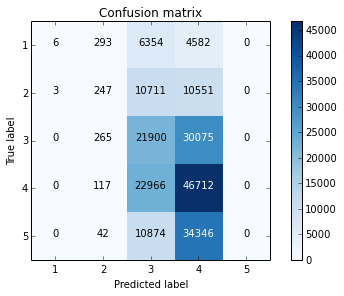

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(matrix_in, classes, cmap=plt.cm.Blues):

    matrix = []
    for s_class in classes:
        row = []
        for o_class in classes:
            row.append(matrix_in[o_class][s_class])
        matrix.append(row)
    cm = np.array(matrix, dtype=int)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks,classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_matrix, [1,2,3,4,5])
    

## Evaluating performance

We built our decision tree using the maximization of the entorpy information gain as a criteria for splitting the data in each node. We trained our model using a training set corresponding to 60% of all the data, found the best depth using a validation set corresponding to 20% of all the data, and measured performance using the remaining 20% of the data. All sets were built using a stratified sampling approach to keep the ratio between classes approximately the same. 

As expected, large trees tend to produce overfitting, and small amounts underfitting. Using the validation set, we found that the best value for the maximum depth of the tree is 2. Lets see how the built classifier compares to a classifier that uses only the mean ratings for a movie:

In [42]:
data = build_features(['timestamp', 'zip_code', 'user_id', 'genre', 'gender','ocupation', 'age'])
train_set, validation_set, test_set = dataset_split(data,'rating')

print "Training set size: " + str(len(train_set.index))
print "Validation set size: " + str(len(validation_set.index))
print "Test set size: " + str(len(test_set.index))

Building features. This may take a while...
Done. Showing 5 first rows:


,movie_id,rating
0,1193,5
1,1193,5
2,1193,4
3,1193,4
4,1193,5


Training set size: 600124
Validation set size: 200041
Test set size: 200044


Calculating score. This may take a while...
Done. Plotting confusion matrix.
Accuracy on test set: 0.378216792306
Mean quadratic error on test set: 1.03707684309
Kappa score on test set: 0.101993281104


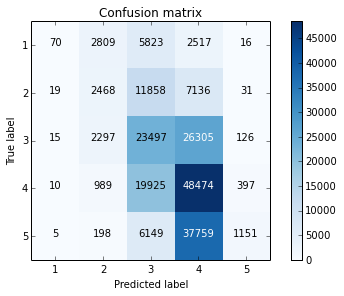

In [50]:
print "Calculating score. This may take a while..."

movies = test_set['movie_id'].unique()
labels = [1,2,3,4,5]

a_priori_cm = {}
for label in labels:
    label_dict = {}
    for other_label in labels:
        label_dict[other_label] = 0
    a_priori_cm[label] = label_dict

i = 0
for movie in movies:    
    i += 1
    if i % 100 == 0:
        print "Calculated score for", str(i), "of", str(len(movies)), "movies."
    counts = label_counts(test_set.ix[data['movie_id'] == movie], 'rating')
    train_counts = label_counts(train_set.ix[data['movie_id'] == movie], 'rating')
    prediction = get_prediction(train_counts)
    for true_label, count in counts.iteritems():
        a_priori_cm[prediction][true_label] += count

    
print "Done. Plotting confusion matrix."
plot_confusion_matrix(a_priori_cm, labels)
(a_priori_accuracy, a_priori_error, a_priori_kappa) = get_statistics(a_priori_cm, labels)
print "======================================"
print "Accuracy on test set: " + str(a_priori_accuracy)
print "Mean quadratic error on test set: " + str(a_priori_error)
print "Kappa score on test set: " + str(a_priori_kappa)

## A different aproach

When we compare the results with the a priori classification, we see that we have only marginal improvements. We propose a different approach to construct the tree, so we can improve the results. Here we will use, instead of the movie genres, there id. In this approach, we can drop al the genre features, which will save us some computational cost. The strategy of construction of the trees is the same as before, but with less features, since we will be using, for each tree, only thes features: **user gender**, **user age** and **user ocupation**. Since there are 3952 different movies (as opposed to the 263 gender combinations we previously used), we should expect larger trees and higher computational costs for both creating the tree and predicting. 

Lets build this second approach and see how it scores.

In [45]:
# building data
data = build_features(['timestamp', 'zip_code', 'user_id', 'genre'])

Building features. This may take a while...
Done. Showing 5 first rows:


,movie_id,rating,gender,age,ocupation
0,1193,5,F,1,10
1,1193,5,M,56,16
2,1193,4,M,25,12
3,1193,4,M,25,7
4,1193,5,M,50,1


Best tree depth: 2
Accuracy on test set: 0.377227010058
Mean quadratic error on test set: 1.03408750075
Kappa score on test set: 0.101186361216
Plotting confusion matrix:


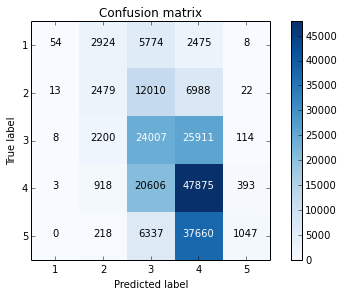

In [51]:
# splitting data
train_set, validation_set, test_set = dataset_split(data,'rating')

# finding best depth
#best_depth, best_tree = find_best_depth(train_set, validation_set, [1,2,3,4])
#best_depth, best_tree = find_best_depth(train_set, validation_set, [2])
cm2, (accuracy2, error2, kappa2) = score(best_tree, test_set, 'rating')

print "======================================"
print "Best tree depth:", best_depth
print "Accuracy on test set: " + str(accuracy2)
print "Mean quadratic error on test set: " + str(error2)
print "Kappa score on test set: " + str(kappa2)
print "Plotting confusion matrix:"
plot_confusion_matrix(cm2, labels)

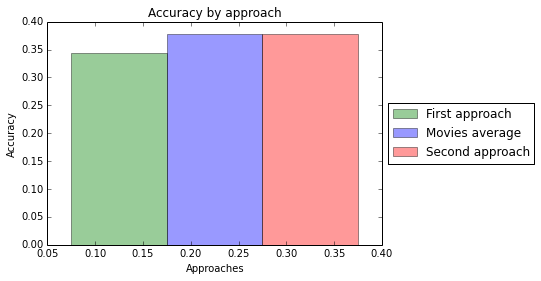

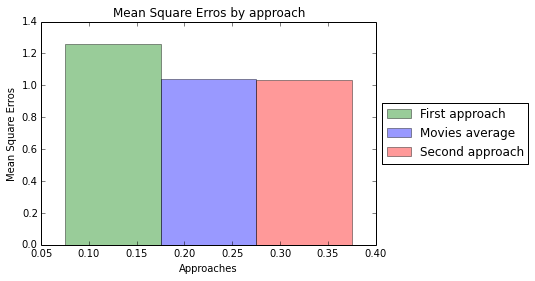

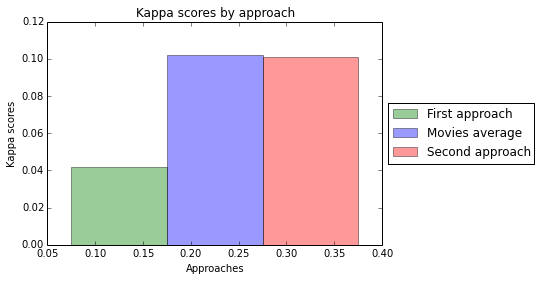

In [65]:
accuracies = [accuracy, a_priori_accuracy, accuracy2]
errors = [error, a_priori_error, error2]
kappas = [kappa, a_priori_kappa, kappa2]
names = ['First approach', 'Movies average', 'Second approach']
colors = ['g','b','r']

def plot_statistic (statistic, names, colors, statistic_name):
    """
    plot statistics
    """
    fig, ax = plt.subplots()
    bar_width = 0.1
    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    for index in range(len(statistic)):
        rect = plt.bar(0.075+bar_width*index, statistic[index], bar_width,
                      alpha=opacity,
                      color=colors[index],
                      error_kw=error_config,
                      label=names[index])
    plt.xlabel('Approaches')
    plt.ylabel(statistic_name)
    plt.title(statistic_name + " by approach")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(
        axis='x', which='both',bottom='off',f
        top='off', labelbottom='off')
    plt.show()
    
plot_statistic(accuracies, names, colors, 'Accuracy')
plot_statistic(errors, names, colors, 'Mean Square Erros')
plot_statistic(kappas, names, colors, 'Kappa scores')